# Evaluering av TrOCR-resultater

In [1]:
import base64
from pathlib import Path

import matplotlib.pyplot as plt
import mlflow
import pandas as pd
from dotenv import load_dotenv
from ipywidgets import interact
from IPython.display import display, Markdown, HTML

import samisk_ocr.trocr
from samisk_ocr.metrics import compute_cer, compute_wer, SpecialCharacterF1

## Last inn miljøvariabler

In [2]:
load_dotenv("../../.env")

True

## Spesialtegn

In [3]:
sami_letters = {
    "sørsamisk": "Ïïö",
    "nordsamisk": "ÁáČčĐđŊŋŠšŦŧŽž",
    "lulesamisk": "ÁáÄäŊŋ",
    "inaresamisk": "ÁáÂâÄäČč",
    "skoltesamis": "ÁáÂâÄäČčƷʒǮǯĐđǦǧǤǥǨǩŊŋÕõŠšŽžÖö",
    "apostroftegn": "ˊʹʼˈ",
}

sami_metrics = {f"f1_{k}": SpecialCharacterF1(alphabet) for k, alphabet in sami_letters.items()}

language_codes = {
    "nordsamisk": "sme",
    "sørsamisk": "sma",
    "lulesamisk": "smj",
    "inaresamisk": "smn",
    "skoltesamis": "sms",
}

## Last inn prediksjoner fra MLFlow

In [4]:
config = samisk_ocr.trocr.config.Config()

mlflow.set_tracking_uri(config.mlflow_url)
mlflow.set_experiment("TrOCR trocr-base-printed finetuning")

# Specify what model we want to load
run_name = "peaceful-doe-996"
run_info = mlflow.search_runs(filter_string=f"run_name = '{run_name}'").squeeze()
run_id = run_info["run_id"]

artifact_path = "predictions/00037025.json"
predictions = mlflow.artifacts.load_dict(f"runs:/{run_id}/{artifact_path}")

metadata = pd.read_csv(config.DATA_PATH / "metadata.csv")

output_folder = Path("output") / f"{run_name}_{Path(artifact_path).stem}"
output_folder.mkdir(parents=True, exist_ok=True)

In [5]:
results = pd.merge(
    pd.DataFrame(predictions),
    metadata.query("file_name.str.startswith('val')"),
    left_on=["urn", "line", "true"],
    right_on=["urn", "line", "text"],
    validate="1:1",
).drop(columns=["text", "xmin", "xmax", "ymin", "ymax", "width", "height", "line", "page", "text_len"])

## Regn ut ytelsesmetrikker for hvert datapunkt

In [6]:
results = results.assign(
    cer=results.apply(lambda row: compute_cer(row["true"], row["predictions"]), axis=1),
    wer=results.apply(lambda row: compute_wer(row["true"], row["predictions"]), axis=1),
    casefolded_cer=results.apply(lambda row: compute_cer(row["true"].casefold(), row["predictions"].casefold()), axis=1),
    casefolded_wer=results.apply(lambda row: compute_wer(row["true"].casefold(), row["predictions"].casefold()), axis=1),
    **{
        key: results.apply(lambda row: metric(row["true"], row["predictions"]), axis=1)
        for key, metric in sami_metrics.items()
    }
)

In [7]:
results.head()

predictions  \
0   Olmus galgga bađčet nuff jottelet go læ vejolaš   
1   ja orostadakættai. Go son læ gærggam baččemest,   
2  de galgga mielkke dolvvujuvvut navetest olgus ja   
3                                      sillijuvvut.   
4             Buok dak æbbarak ja littek, mak adnu-   

                                               true  \
0   Olmuš galgga baččet nuft jottelet go læ vejolaš   
1   ja orostadakættai. Go son læ gærggam baččemest,   
2  de galgga mielkke dolvvujuvvut navetest olgus ja   
3                                      sillijuvvut.   
4             Buok dak æbbarak ja littek, mak adnu-   

                                   urn  \
0  URN_NBN_no-nb_digibok_2011110712003   
1  URN_NBN_no-nb_digibok_2011110712003   
2  URN_NBN_no-nb_digibok_2011110712003   
3  URN_NBN_no-nb_digibok_2011110712003   
4  URN_NBN_no-nb_digibok_2011110712003   

                                           file_name langcodes  page_30  \
0  val/URN_NBN_no-nb_digibok_2011110712003_0013_0...   ['sme']    False   
1  val/URN_NBN_no-nb_digibok_2011110712003_0013_0...   ['sme']    False   
2  val/URN_NBN_no-nb_digibok_2011110712003_0013_0...   ['sme']    False   
3  val/URN_NBN_no-nb_digibok_2011110712003_0013_0...   ['sme']    False   
4  val/URN_NBN_no-nb_digibok_2011110712003_0013_0...   ['sme']    False   

   gt_pix      cer    wer  casefolded_cer  casefolded_wer  f1_sørsamisk  \
0   False  0.06383  0.375         0.06383           0.375           NaN   
1   False  0.00000  0.000         0.00000           0.000           NaN   
2   False  0.00000  0.000         0.00000           0.000           NaN   
3   False  0.00000  0.000         0.00000           0.000           NaN   
4   False  0.00000  0.000         0.00000           0.000           NaN   

   f1_nordsamisk  f1_lulesamisk  f1_inaresamisk  f1_skoltesamis  \
0       0.571429            NaN        0.666667        0.571429   
1       1.000000            NaN        1.000000        1.000000   
2            NaN            NaN             NaN             NaN   
3            NaN            NaN             NaN             NaN   
4            NaN            NaN             NaN             NaN   

   f1_apostroftegn  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN

## Sammendrag av ytelse

In [8]:
results.describe(percentiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95])

cer          wer  casefolded_cer  casefolded_wer  f1_sørsamisk  \
count  2169.000000  2169.000000     2169.000000     2169.000000     53.000000   
mean      0.070495     0.173840        0.067970        0.170845      0.688470   
std       0.302325     0.301895        0.298840        0.300005      0.444669   
min       0.000000     0.000000        0.000000        0.000000      0.000000   
5%        0.000000     0.000000        0.000000        0.000000      0.000000   
10%       0.000000     0.000000        0.000000        0.000000      0.000000   
25%       0.000000     0.000000        0.000000        0.000000      0.000000   
50%       0.000000     0.000000        0.000000        0.000000      1.000000   
75%       0.038462     0.250000        0.038462        0.250000      1.000000   
90%       0.123630     0.500000        0.115496        0.500000      1.000000   
95%       0.300000     1.000000        0.285714        1.000000      1.000000   
max       7.166667     3.000000        7.166667        3.000000      1.000000   

       f1_nordsamisk  f1_lulesamisk  f1_inaresamisk  f1_skoltesamis  \
count    1538.000000    1346.000000     1391.000000     1556.000000   
mean        0.935032       0.944133        0.944739        0.930476   
std         0.211755       0.199524        0.196247        0.218121   
min         0.000000       0.000000        0.000000        0.000000   
5%          0.500000       0.666667        0.666667        0.500000   
10%         0.857143       0.888889        0.888889        0.813657   
25%         1.000000       1.000000        1.000000        1.000000   
50%         1.000000       1.000000        1.000000        1.000000   
75%         1.000000       1.000000        1.000000        1.000000   
90%         1.000000       1.000000        1.000000        1.000000   
95%         1.000000       1.000000        1.000000        1.000000   
max         1.000000       1.000000        1.000000        1.000000   

       f1_apostroftegn  
count              4.0  
mean               0.0  
std                0.0  
min                0.0  
5%                 0.0  
10%                0.0  
25%                0.0  
50%                0.0  
75%                0.0  
90%                0.0  
95%                0.0  
max                0.0

## Concat CER og WER

In [9]:
concat_pred = " ".join(results["predictions"])
concat_true = " ".join(results["true"])

concat_cer = compute_cer(concat_true, concat_pred)
concat_wer = compute_wer(concat_true, concat_pred)

print(f"Concat CER: {concat_cer}")
print(f"Concat WER: {concat_wer}")

Concat CER: 0.05353780664174421
Concat WER: 0.16800312927831018


## Sammendrag av ytelse per språk

In [10]:
@interact(language=language_codes)
def display_performance(language: str) -> None:
    df = results.query(f"langcodes == \"['{language}']\"")
    display(df.describe(percentiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]))

    concat_pred = " ".join(df["predictions"])
    concat_true = " ".join(df["true"])
    
    concat_cer = compute_cer(concat_true, concat_pred)
    concat_wer = compute_wer(concat_true, concat_pred)
    
    print(f"Concat CER: {concat_cer}")
    print(f"Concat WER: {concat_wer}")

interactive(children=(Dropdown(description='language', options={'nordsamisk': 'sme', 'sørsamisk': 'sma', 'lule…

## Visualisering av bilder med lavest CER


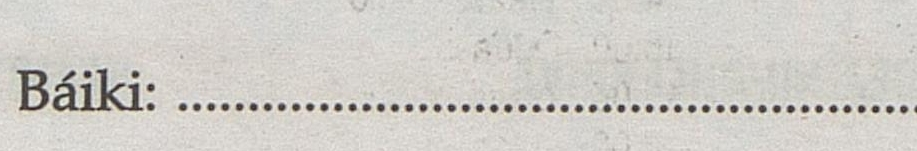
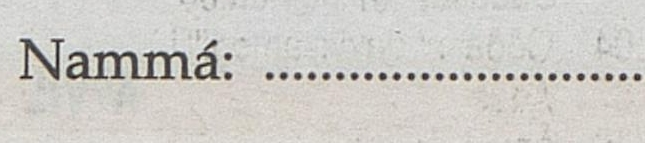
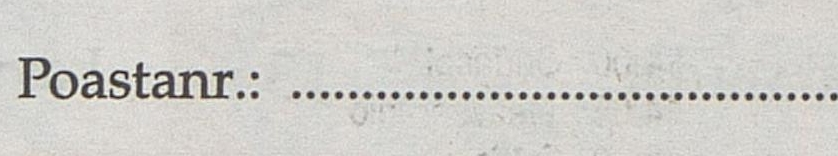
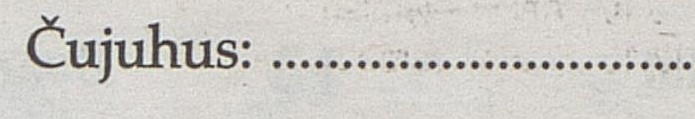
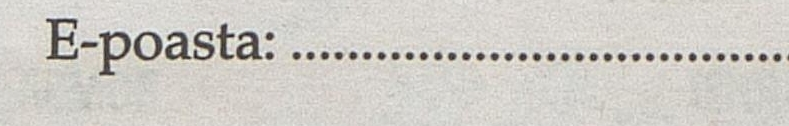
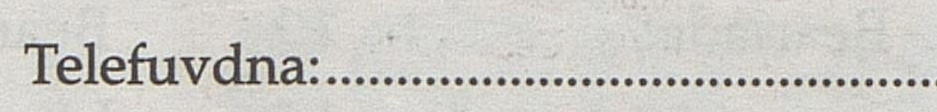
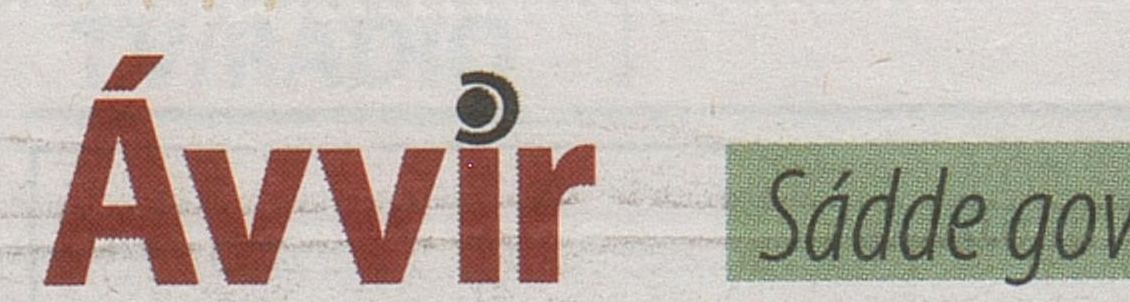
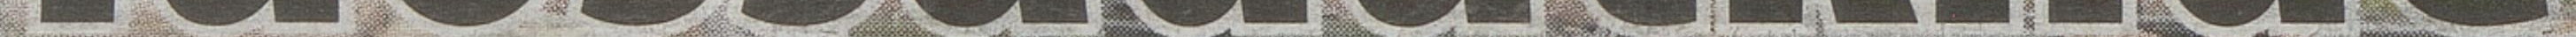
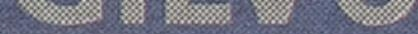
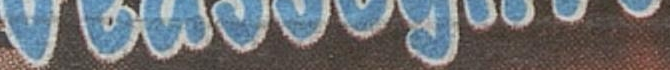
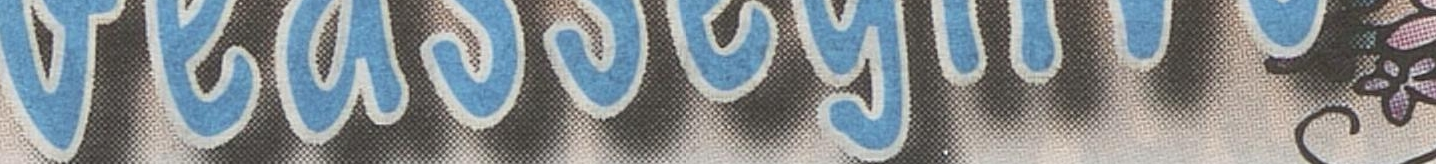
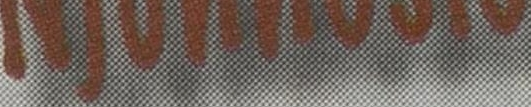
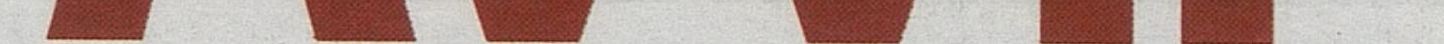
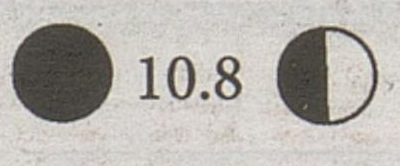
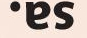
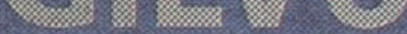
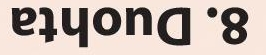
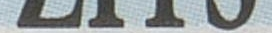
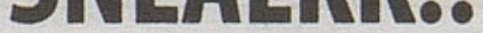
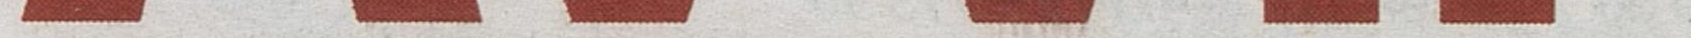
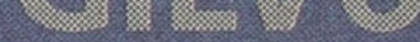
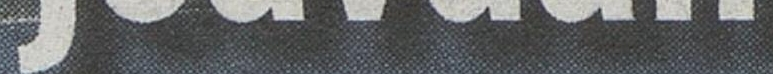
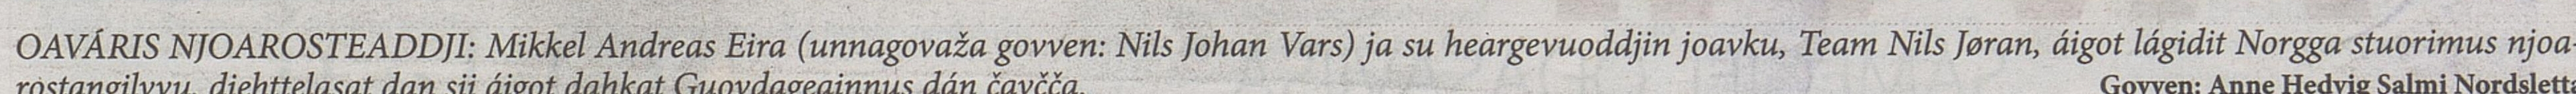
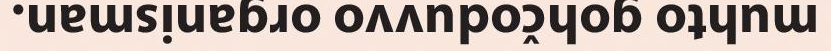
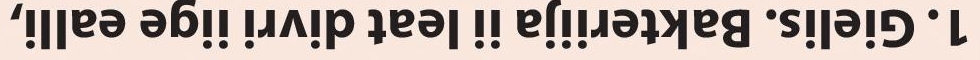
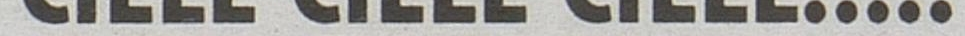
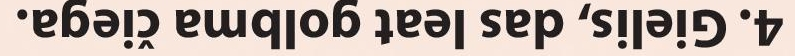
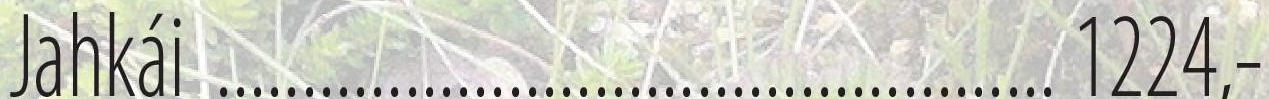
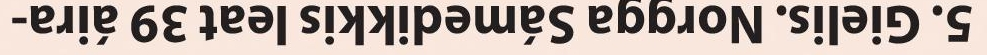
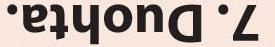
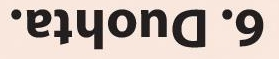
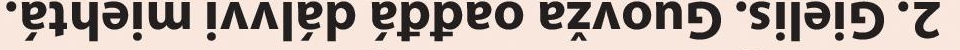
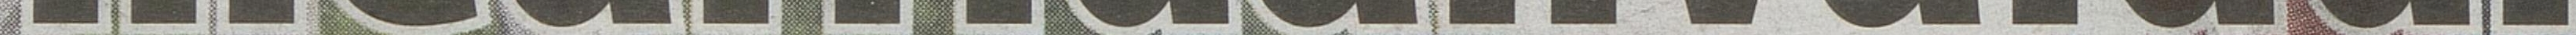
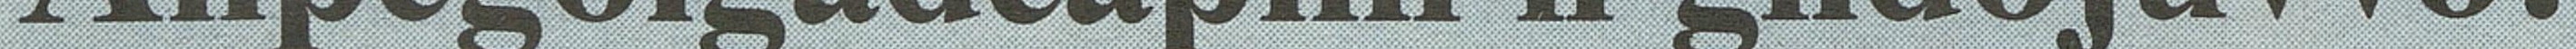
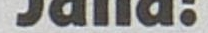
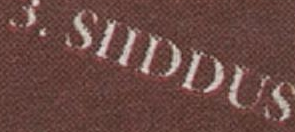
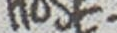
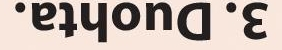
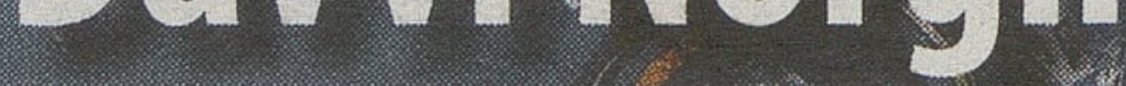
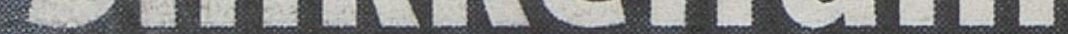
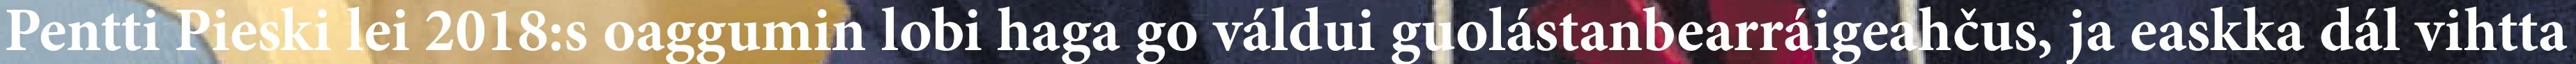
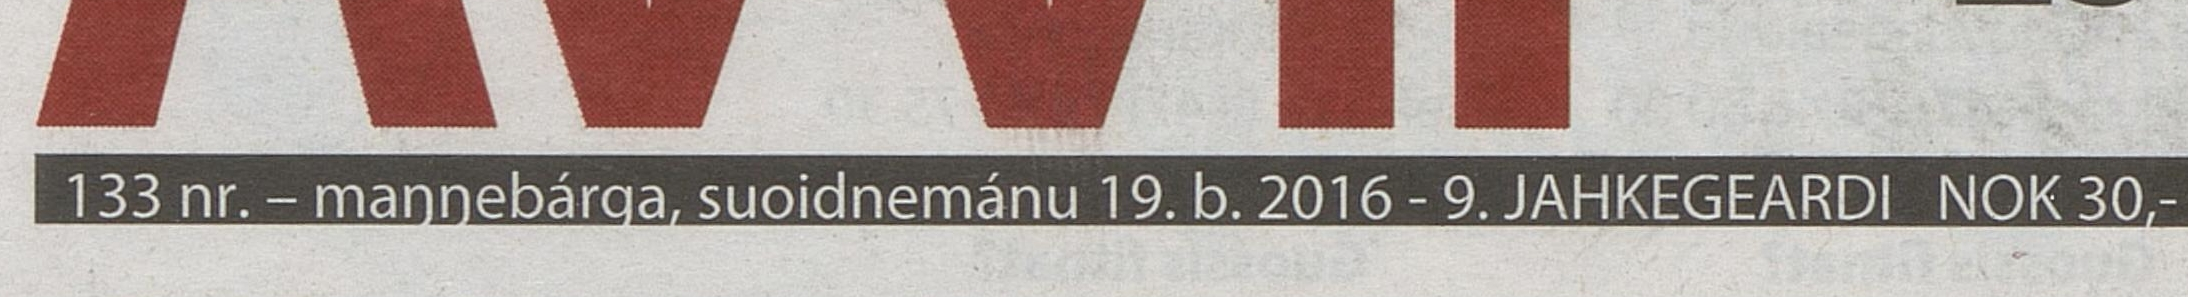
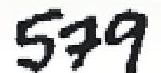
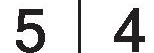
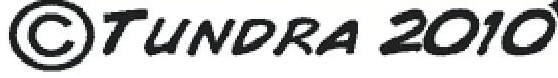
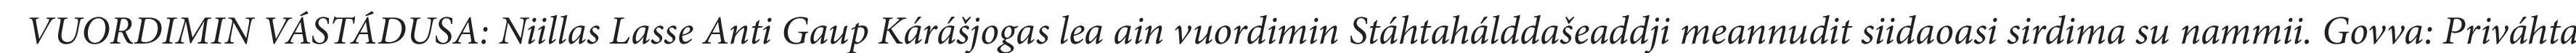
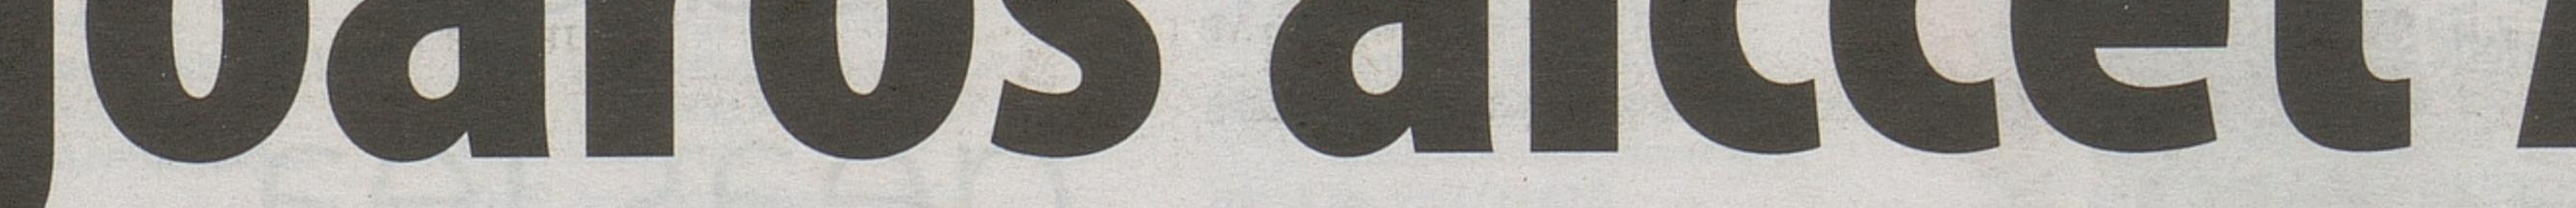
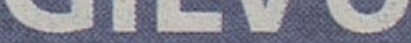
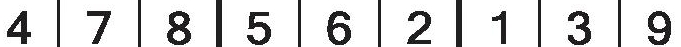
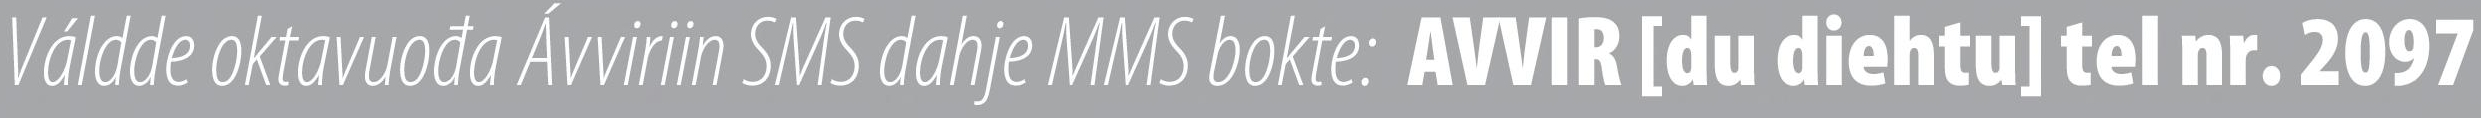
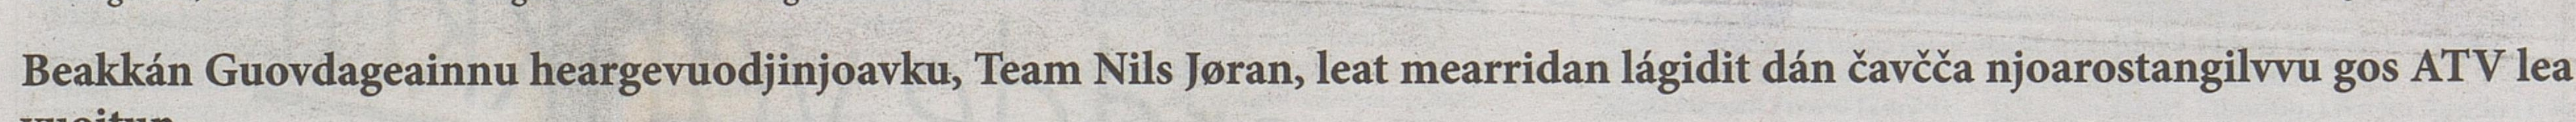
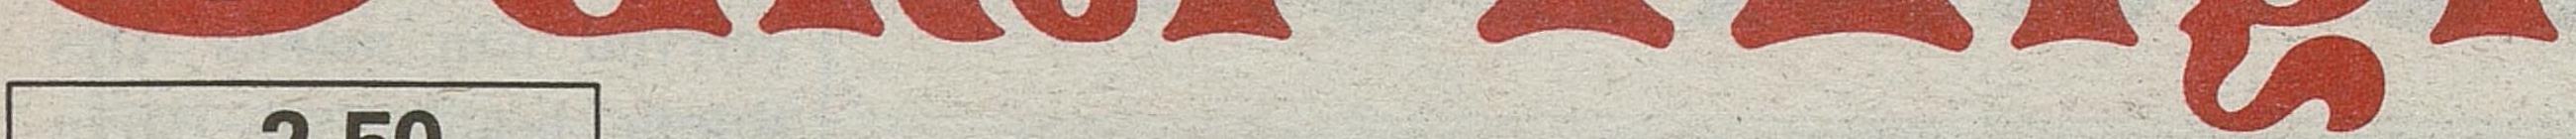
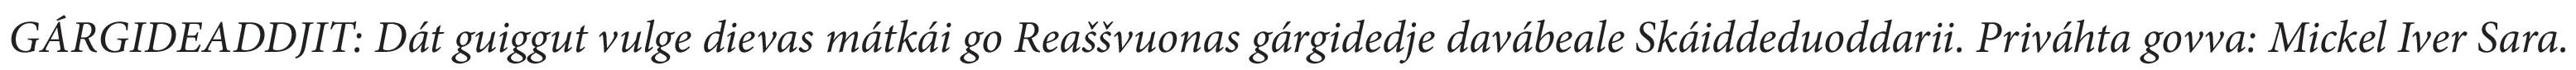
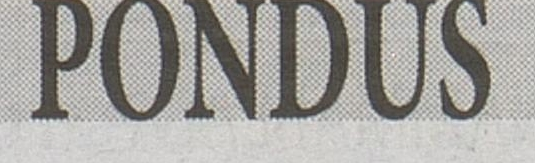
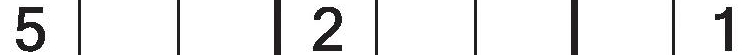
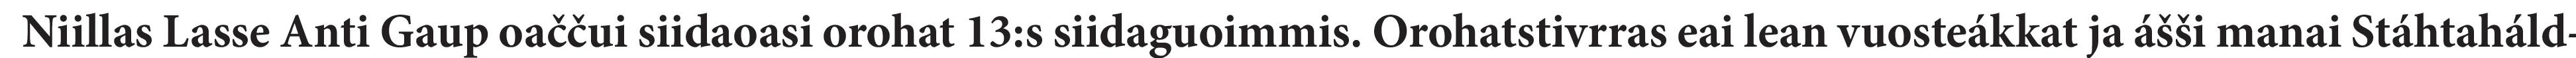
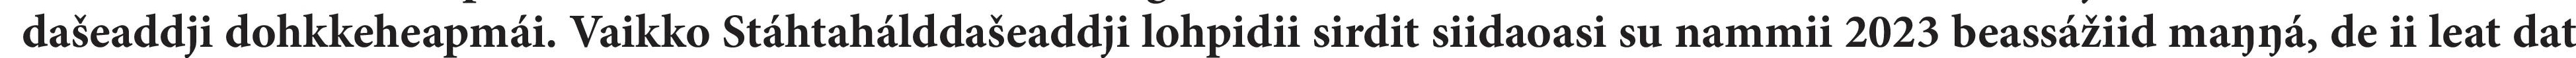
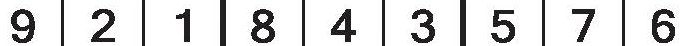
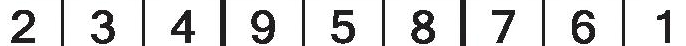
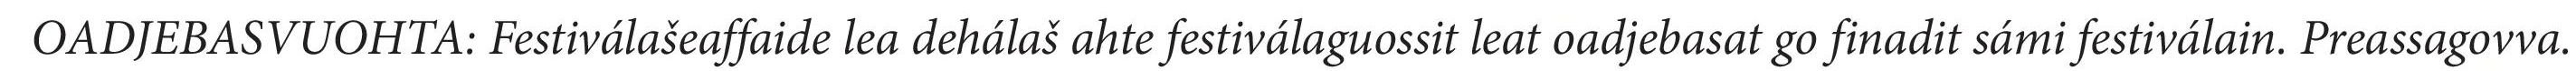
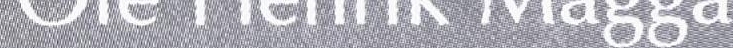
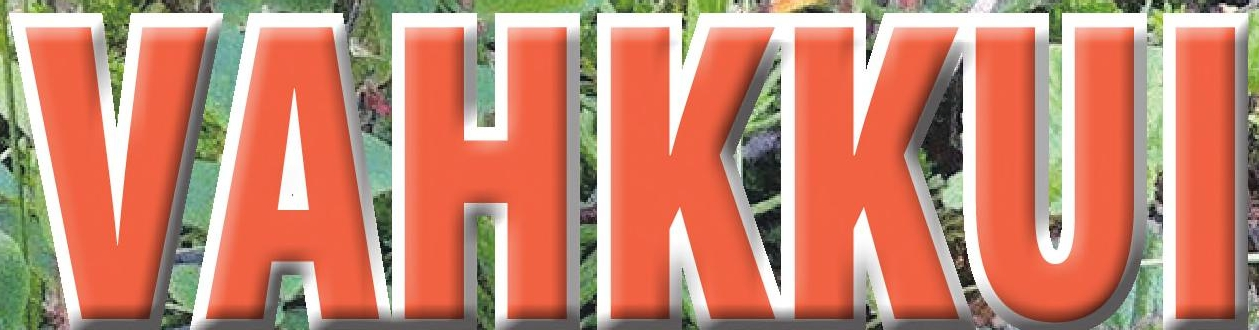
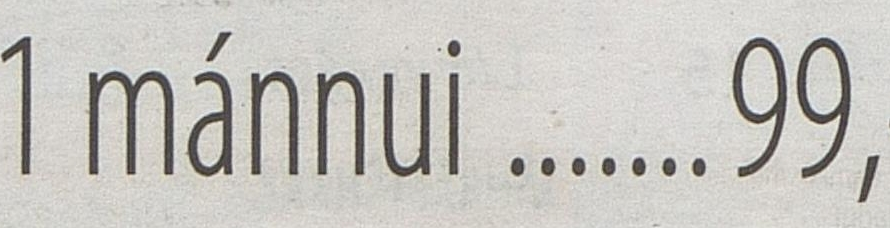
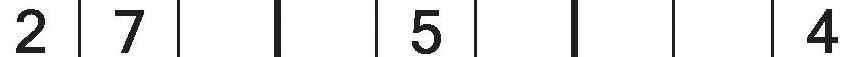
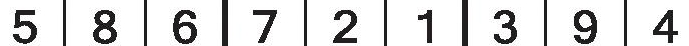
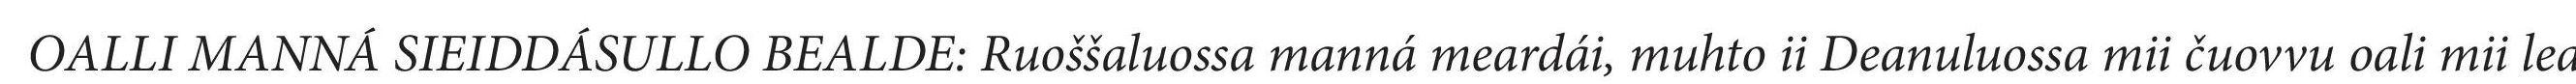
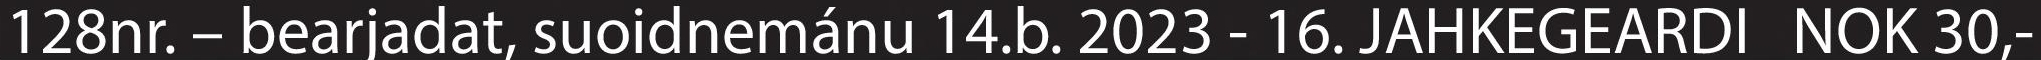
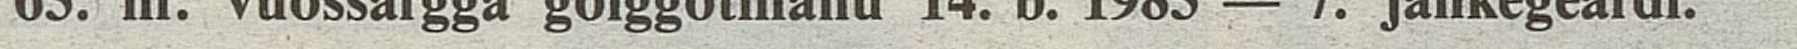
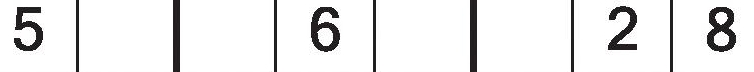
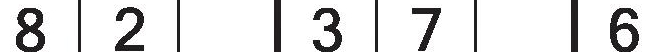
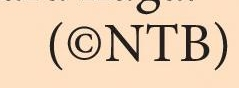
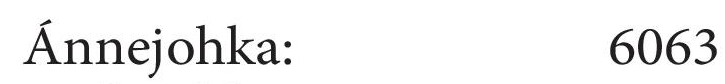
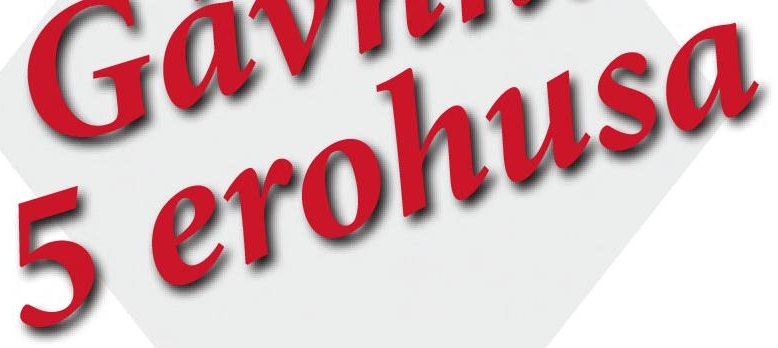

8770910

In [11]:
def encode_image_from_file(file_name: str) -> str:
    image_path = config.DATA_PATH / file_name
    encoded_image = base64.b64encode(image_path.read_bytes()).decode('utf-8')
    return f'<img src="data:image/{image_path.suffix};base64,{encoded_image}"/>'


def get_worst_lines_df(
    df: pd.DataFrame,
    num_bad_to_show: int = 100,
    sort_by: str = "cer",
) -> pd.DataFrame:
    return df.sort_values(sort_by, ascending=False).head(num_bad_to_show)


def get_worst_line_html_table(df, columns: tuple[str] = ("true", "predictions", "cer", "wer")) -> str:
    return (
        df.rename(columns={"file_name": "image"})
        [["image", *columns]]
        .to_html(
            formatters={"image": encode_image_from_file},
            escape=False,
            index=False,
            float_format=lambda x: f"{x:.4f}"
        )
    )

worst_lines = get_worst_lines_df(results, num_bad_to_show=100)
display(HTML(get_worst_line_html_table(worst_lines)))

(output_folder / "worst_lines.html").write_text(get_worst_line_html_table(worst_lines))

In [12]:
for language in language_codes.values():
    results.query(f"langcodes == \"['{language}']\"")
    (output_folder / f"worst_lines_{language}.html").write_text(get_worst_line_html_table(worst_lines))
    
@interact(language=language_codes)
def show_worst(language):
    language_df = results.query(f"langcodes == \"['{language}']\"")
    display(HTML(get_worst_line_html_table(get_worst_lines_df(language_df))))

interactive(children=(Dropdown(description='language', options={'nordsamisk': 'sme', 'sørsamisk': 'sma', 'lule…

## Beregn ytelsesmetrikker uten de 100 verste

In [13]:
without_100_worst = results.sort_values("cer").head(-100)
cer = without_100_worst["cer"].mean()
wer = without_100_worst["wer"].mean()

# Concat CER and WER
without_100_worst_pred = " ".join(without_100_worst["predictions"])
without_100_worst_true = " ".join(without_100_worst["true"])
concat_cer = compute_cer(ground_truth=without_100_worst_true, transcription=without_100_worst_pred)
concat_wer = compute_wer(ground_truth=without_100_worst_true, transcription=without_100_worst_pred)


display(Markdown(f"**Gjennomsnitts-CER og WER beregnet uten de 100 linjene med lavest CER:**  \nCER: {cer:.4f}, WER: {wer:.4f}"))
display(Markdown(f"**Konkatenerings-CER og WER beregnet uten de 100 linjene med lavest CER:**  \nCER: {concat_cer:.4f}, WER: {concat_wer:.4f}"))

**Gjennomsnitts-CER og WER beregnet uten de 100 linjene med lavest CER:**  
CER: 0.0262, WER: 0.1331

**Konkatenerings-CER og WER beregnet uten de 100 linjene med lavest CER:**  
CER: 0.0297, WER: 0.1379

## Plott histogram over CER og WER

(0.007692307692307693, 7.883333333333335)

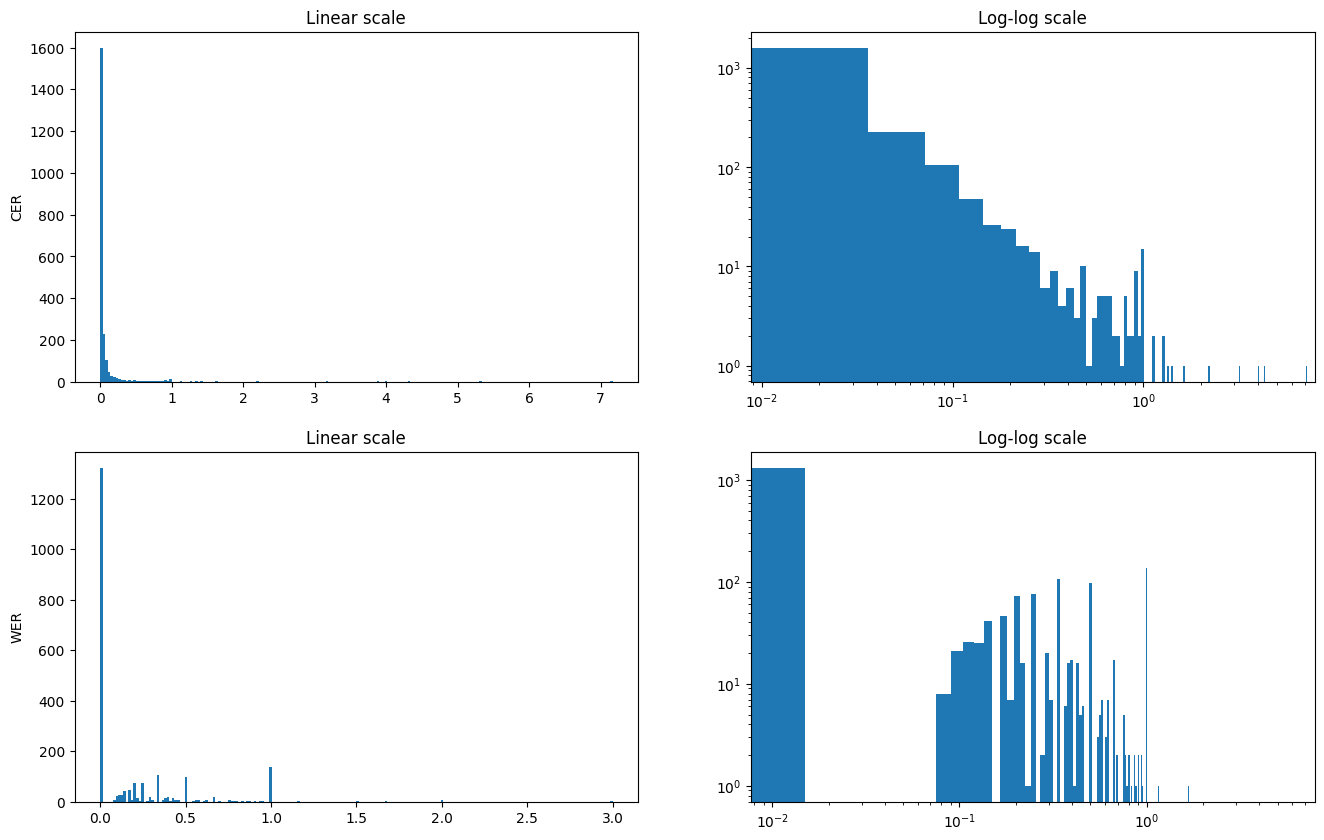

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

results["cer"].plot.hist(bins=200, ax=axes[0, 0])
axes[0, 0].set_title("Linear scale")
axes[0, 0].set_ylabel("CER")

results["cer"].plot.hist(bins=200, ax=axes[0, 1])
axes[0, 1].set_xscale("log")
axes[0, 1].set_yscale("log")
axes[0, 1].set_title("Log-log scale")
axes[0, 1].set_ylabel("")
axes[0, 1].set_xlim(results["cer"][results["cer"] != 0].min()*0.7, results["cer"].max() * 1.1)

results["wer"].plot.hist(bins=200, ax=axes[1, 0])
axes[1, 0].set_title("Linear scale")
axes[1, 0].set_ylabel("WER")

results["wer"].plot.hist(bins=200, ax=axes[1, 1])
axes[1, 1].set_xscale("log")
axes[1, 1].set_yscale("log")
axes[1, 1].set_title("Log-log scale")
axes[1, 1].set_ylabel("")
axes[1, 1].set_xlim(results["wer"][results["wer"] != 0].min()*0.1, results["cer"].max() * 1.1)